In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm.notebook

import torch
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

from svd_utils import GraphConvolutionBSSVD

In [2]:
args = {
    'cuda': False,
    'dataset': 'cora',
    'datapath': '../DropEdge/data/',
    'fastmode': False,
    'seed': 42,
    'epochs': 400,
    'lr': 0.01,
    'lradjust': False,
    'weight_decay': 0.005,
    'warm_start': '',
    'debug': True,
    'early_stopping': 400,
    'no_tensorboard': False,
    'normalization': 'FirstOrderGCN',
    'sampling_percent': 0.7,
    'task_type': 'full',
}

sampler = Sampler(args['dataset'], args['datapath'], args['task_type'])
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(cuda=args['cuda'])
nfeat = sampler.nfeat
nclass = sampler.nclass

model_args = {
    'nfeat': sampler.nfeat,
    'nclass': sampler.nclass,
    'nhid': 128,
    'nhidlayer': 1,
    'dropout': 0.8,
    'baseblock': 'mutigcn',
    'inputlayer': 'gcn',
    'outputlayer': 'gcn',
    'nbaselayer': 6,
    'activation': F.relu,
    'withbn': False,
    'withloop': False,
    'aggrmethod': 'nores',
    'mixmode': False
}

Load full supervised task.


In [3]:
def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [4]:
def fit_model(model, idx_train, idx_val, num_epochs=10, verbose=0):
    (train_adj, train_fea) = sampler.randomedge_sampler(
        percent=1.0,
        normalization=args['normalization'],
        cuda=args['cuda'])
    (val_adj, val_fea) = sampler.get_val_set(normalization=args['normalization'], cuda=args['cuda'])
    
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(parameters, lr=args['lr'], weight_decay=args['weight_decay'])
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[200, 300, 400, 500, 600, 700],
                                               gamma=0.5)
    
    history = defaultdict(list)
    for ep in range(1, num_epochs+1):
        model.train()
        optimizer.zero_grad()
        output = model(train_fea, train_adj)
        
        train_loss = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        
        train_loss.backward()
        optimizer.step()
        
        history['train_loss'].append(train_loss.item())
        history['train_acc'].append(acc_train.item())
        
        # Validate
        model.eval()
        output = model(val_fea, val_adj)
        val_loss = F.nll_loss(output[idx_val], labels[idx_val]).item()
        val_acc = accuracy(output[idx_val], labels[idx_val]).item()
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if verbose > 0 and (ep % verbose == 0 or ep == num_epochs):
            print("epoch: {:3} TRAIN: acc={:.3}; loss={:.3} VALID: acc={:.3}; loss={:.3}".format(
                ep,
                acc_train.item(), train_loss.item(),
                val_acc, val_loss
            ))
            
    
        
    return history

In [36]:
def plot_history(history, test_loss=None, test_acc=None, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    
    if title:
        fig.suptitle(title, fontsize=16)

    axs[0].plot(history['train_loss'], label='train')
    axs[0].plot(history['val_loss'], label='val')
    if test_loss:
        axs[0].axhline(test_loss, label='test after traning', color='red', linestyle="--")
    axs[0].legend()
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")

    axs[1].plot(history['train_acc'], label='train')
    axs[1].plot(history['val_acc'], label='val')
    if test_acc:
        axs[1].axhline(test_acc, label='test after traning', color='red', linestyle="--")
    axs[1].legend()
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("accuracy")

epoch: 100 TRAIN: acc=0.43; loss=1.39 VALID: acc=0.446; loss=1.3
epoch: 200 TRAIN: acc=0.534; loss=1.12 VALID: acc=0.614; loss=0.99
epoch: 300 TRAIN: acc=0.666; loss=0.953 VALID: acc=0.716; loss=0.795
epoch: 400 TRAIN: acc=0.716; loss=0.791 VALID: acc=0.726; loss=0.729
epoch: 500 TRAIN: acc=0.704; loss=0.848 VALID: acc=0.748; loss=0.698
epoch: 600 TRAIN: acc=0.756; loss=0.774 VALID: acc=0.758; loss=0.704
epoch: 700 TRAIN: acc=0.724; loss=0.793 VALID: acc=0.766; loss=0.738
epoch: 800 TRAIN: acc=0.743; loss=0.73 VALID: acc=0.754; loss=0.675
epoch: 900 TRAIN: acc=0.711; loss=0.848 VALID: acc=0.758; loss=0.749
epoch: 1000 TRAIN: acc=0.748; loss=0.716 VALID: acc=0.78; loss=0.679
epoch: 1100 TRAIN: acc=0.727; loss=0.746 VALID: acc=0.776; loss=0.693
epoch: 1200 TRAIN: acc=0.75; loss=0.727 VALID: acc=0.758; loss=0.68
TEST: acc=0.74; loss=0.84


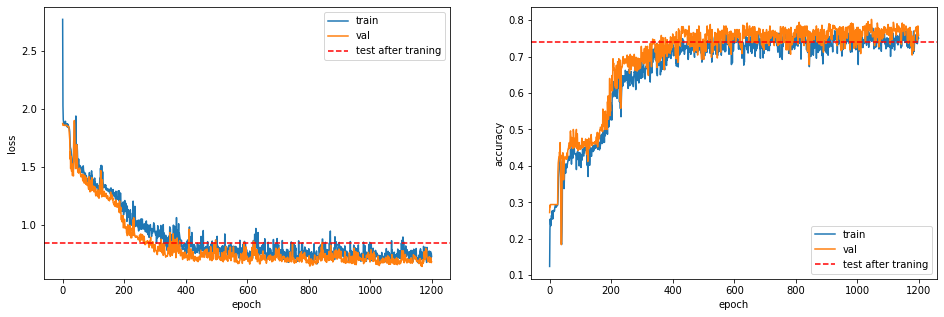

In [6]:
base_model = GCNModel(**model_args)

history = fit_model(base_model, idx_train, idx_val, num_epochs=1200, verbose=100)

test_loss, test_acc = test_model(base_model, test_adj, test_fea)
print("TEST: acc={:.3}; loss={:.3}".format(test_acc, test_loss))

plot_history(history, test_loss, test_acc)

### Weight analysis

In [17]:
def multicollinearyty_det_factor(weight):
    weight = weight.astype(np.float64)
    det = np.linalg.det(weight)
    return det

In [8]:
layer = base_model.midlayer[0].model.hiddenlayers[0]
base_weight = layer.weight

In [9]:
det_of_wwT = multicollinearyty_det_factor(base_weight.detach().numpy())
print("Determinant of WW^T: ", det_of_wwT)

Determinant of WW^T:  -0.0


In [10]:
base_model.midlayer[0].model.hiddenlayers[0].weight.dtype

torch.float32

Text(0.5, 0, 'i')

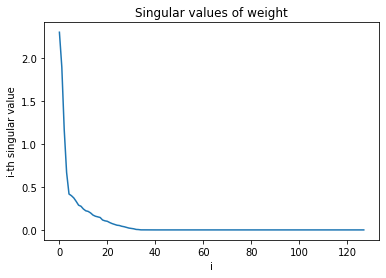

In [11]:
U, s, V = torch.svd(base_weight)

plt.title("Singular values of weight")
plt.plot(s.detach().numpy())
plt.ylabel("i-th singular value")
plt.xlabel("i")

1.8345756412452186e-05


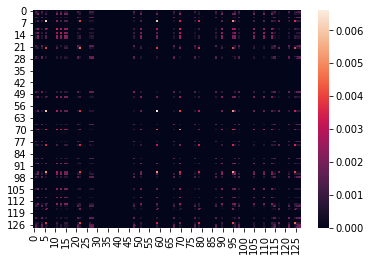

In [12]:
cov = pd.DataFrame(base_weight.detach().numpy()).cov()
sns.heatmap(cov.apply(abs))
print(cov.mean().mean())

In [13]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
#     new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    new_model.midlayer[0].model.hiddenlayers[0] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[0], r)
#     new_model.midlayer[0].model.hiddenlayers[1] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[1], r)
#     new_model.midlayer[0].model.hiddenlayers[2] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[2], r)
#     new_model.to(device)
    return new_model

Text(0, 0.5, 'determinant of weight')

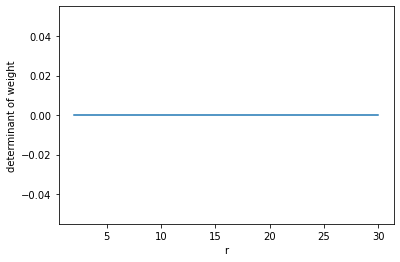

In [14]:
singular_values = defaultdict(list)
r_hist = []
for r in range(2, 31):
    new_model = make_new_model(base_model, r)
    fit_model(new_model, idx_train, idx_val, num_epochs=50, verbose=0)
    
    svd_layer = new_model.midlayer[0].model.hiddenlayers[0]
    svd_weight = torch.mm(torch.mm(svd_layer.U, torch.diag(svd_layer.s)), svd_layer.Vt).detach().numpy()
    r_hist.append((r, multicollinearyty_det_factor(svd_weight)))
    
    singular_values[r] = svd_layer.s.detach().numpy()
    
r_hist = np.array(r_hist)
plt.plot(r_hist[:, 0], r_hist[:, 1])
plt.xlabel('r')
plt.ylabel('determinant of weight')

Text(0.5, 0, 'i')

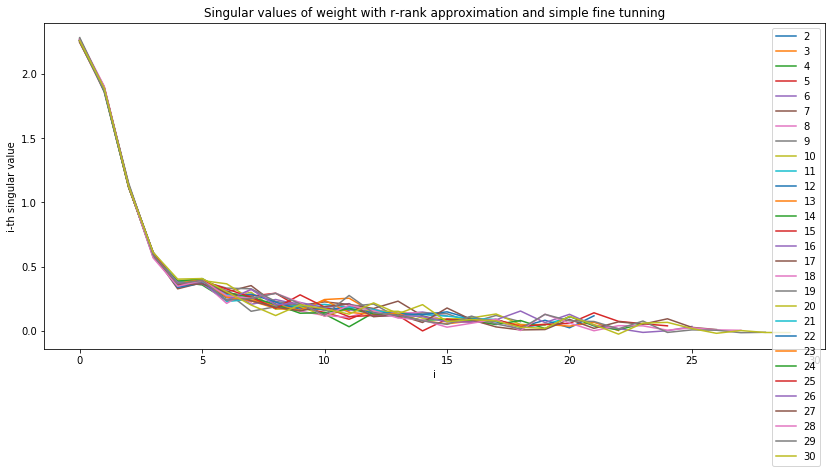

In [15]:
plt.figure(figsize=(14, 6))
plt.title("Singular values of weight with r-rank approximation and simple fine tunning")

for r in singular_values.keys():
    plt.plot(singular_values[r], label=r)
    
plt.legend()
plt.ylabel("i-th singular value")
plt.xlabel("i")

0.00012226632923174996


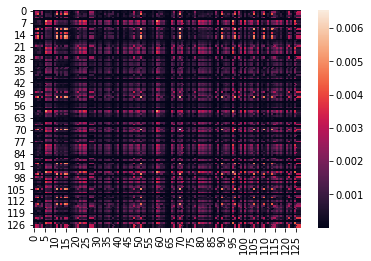

In [16]:
cov = pd.DataFrame(svd_weight).cov()
sns.heatmap(cov.apply(abs))
print(cov.mean().mean())

## TODO:
* дообучать слои по одному. Разложил 1 слой, дообучил, разложил 2 и тд
* отбор колонок в матрице (снижение размерности)

* **ОПТИОНАЛЬНО** Обучение нейронки по блокам: Замораживаем 1 блок, обучаем. Замораживаем другой блок, обучаем и тд

In [24]:
num_epochs_per_layer = 60 

new_model = copy.deepcopy(base_model)
parallel_traning_history = []
parallel_traning_history_test = []
for i in range(model_args['nbaselayer']):
    new_model.midlayer[0].model.hiddenlayers[i] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i], r)
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    parallel_traning_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    parallel_traning_history_test.append((test_loss, test_acc))
    print("Fitted model after decompose {}-th hiddenlayer.".format(i))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

Fitted model after decompose 0-th hiddenlayer.
TEST: acc=0.753; loss=0.883

Fitted model after decompose 1-th hiddenlayer.
TEST: acc=0.744; loss=0.911

Fitted model after decompose 2-th hiddenlayer.
TEST: acc=0.738; loss=0.886

Fitted model after decompose 3-th hiddenlayer.
TEST: acc=0.628; loss=1.08

Fitted model after decompose 4-th hiddenlayer.
TEST: acc=0.639; loss=1.05

Fitted model after decompose 5-th hiddenlayer.
TEST: acc=0.725; loss=0.904



In [25]:
new_model = copy.deepcopy(base_model)
train_only_decomposed_history = []
train_only_decomposed_history_test = []
for i in range(model_args['nbaselayer']):
    new_model.requires_grad_(False)
    
    new_model.midlayer[0].model.hiddenlayers[i] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[i], r)
    new_model.midlayer[0].model.hiddenlayers[i].requires_grad_(True)
    
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    train_only_decomposed_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    train_only_decomposed_history_test.append((test_loss, test_acc))
    print("Fitted model after decompose {}-th hiddenlayer.".format(i))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

Fitted model after decompose 0-th hiddenlayer.
TEST: acc=0.674; loss=0.917

Fitted model after decompose 1-th hiddenlayer.
TEST: acc=0.741; loss=0.892

Fitted model after decompose 2-th hiddenlayer.
TEST: acc=0.754; loss=0.886

Fitted model after decompose 3-th hiddenlayer.
TEST: acc=0.765; loss=0.875

Fitted model after decompose 4-th hiddenlayer.
TEST: acc=0.758; loss=0.831

Fitted model after decompose 5-th hiddenlayer.
TEST: acc=0.768; loss=0.82



In [26]:
new_model = copy.deepcopy(base_model)
just_ft_history = []
just_ft_history_test = []
for i in range(model_args['nbaselayer']):
    history_i = fit_model(new_model, idx_train, idx_val, num_epochs=num_epochs_per_layer, verbose=-1)
    just_ft_history.append(history_i)
    
    test_loss, test_acc = test_model(new_model, test_adj, test_fea)
    just_ft_history_test.append((test_loss, test_acc))
    print("TEST: acc={:.3}; loss={:.3}\n".format(test_acc, test_loss))

TEST: acc=0.738; loss=0.84

TEST: acc=0.722; loss=0.849

TEST: acc=0.687; loss=0.922

TEST: acc=0.57; loss=1.19

TEST: acc=0.671; loss=0.939

TEST: acc=0.683; loss=0.912



In [29]:
def concat_list_of_histories(lst_of_histories):
    history = defaultdict(list)
    for key in lst_of_histories[0].keys():
        for history_i in lst_of_histories:
            history[key] += history_i[key]
    return history

In [41]:
_parallel_traning_history = concat_list_of_histories(parallel_traning_history)
_train_only_decomposed_history = concat_list_of_histories(train_only_decomposed_history)
_just_ft_history = concat_list_of_histories(just_ft_history)

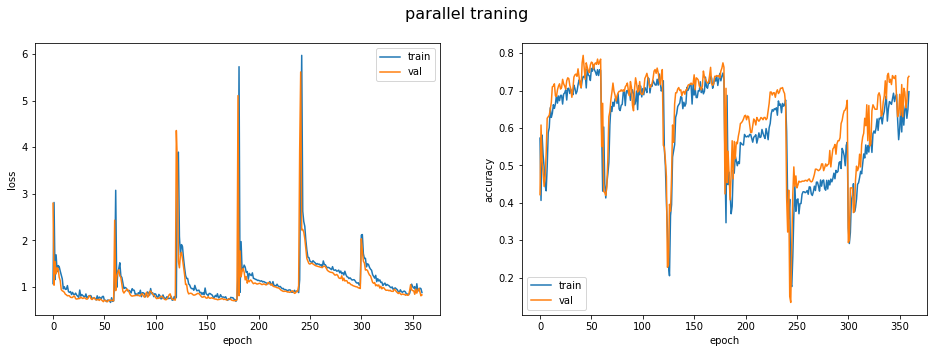

In [42]:
plot_history(_parallel_traning_history, title="parallel traning")

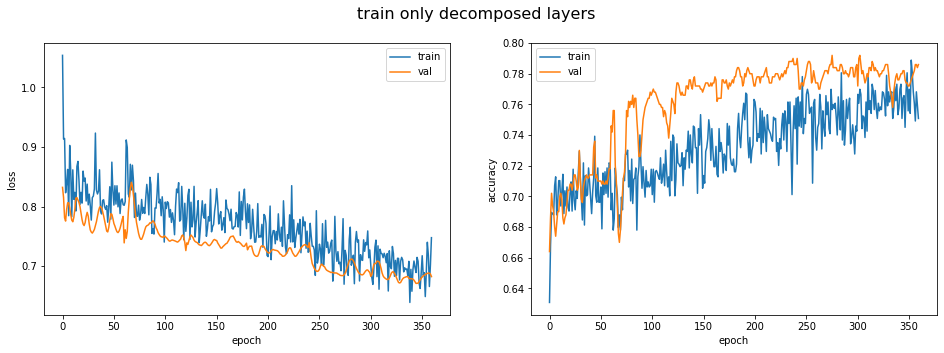

In [43]:
plot_history(_train_only_decomposed_history, title="train only decomposed layers")

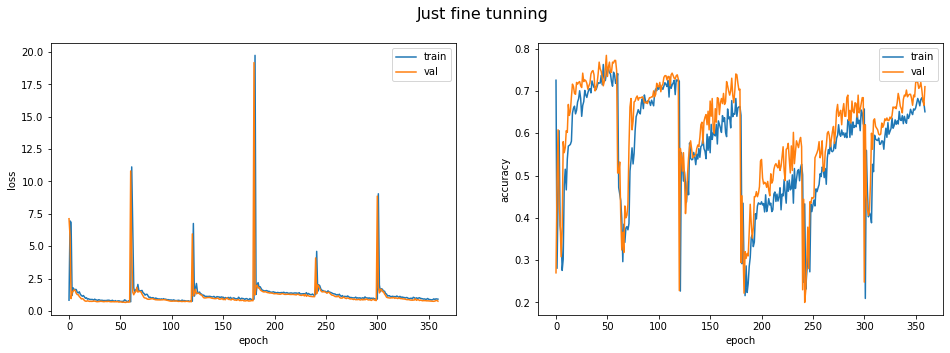

In [44]:
plot_history(_just_ft_history, title="Just fine tunning")

Text(0, 0.5, 'acc')

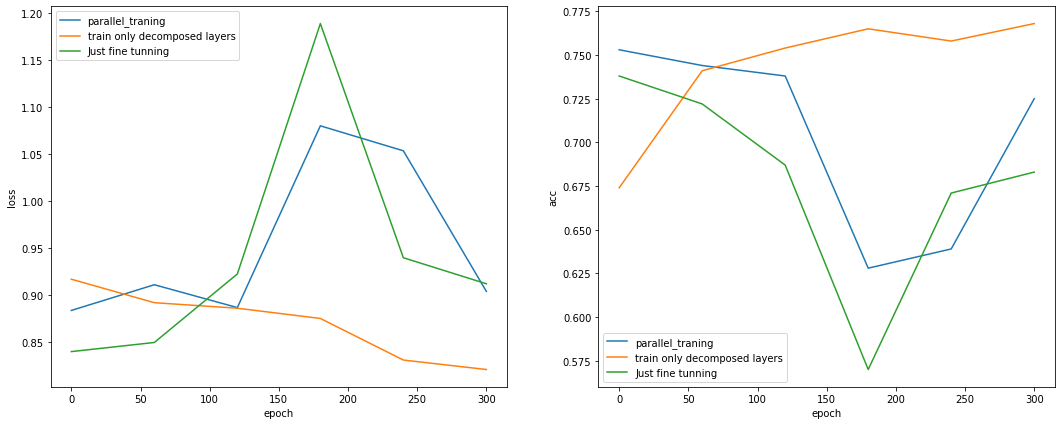

In [55]:
parallel_traning_history_test = np.array(parallel_traning_history_test)
train_only_decomposed_history_test = np.array(train_only_decomposed_history_test)
just_ft_history_test = np.array(just_ft_history_test)

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

xx = [num_epochs_per_layer*i for i in range(model_args['nbaselayer'])]

axs[0].plot(xx, parallel_traning_history_test[:, 0], label="parallel_traning")
axs[0].plot(xx, train_only_decomposed_history_test[:, 0], label="train only decomposed layers")
axs[0].plot(xx, just_ft_history_test[:, 0], label="Just fine tunning")
axs[0].legend()
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("loss")

axs[1].plot(xx, parallel_traning_history_test[:, 1], label="parallel_traning")
axs[1].plot(xx, train_only_decomposed_history_test[:, 1], label="train only decomposed layers")
axs[1].plot(xx, just_ft_history_test[:, 1], label="Just fine tunning")
axs[1].legend()
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("acc")